# 2D CNN Notebook

This notebook implements a NN whose input is a jet image generatd in the accompanying notebook.

In [1]:
import pandas as pd
import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow.keras.utils

from datetime import datetime
from packaging import version

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle
import pickle
import os

In [2]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
if not os.path.isdir("model"):
    os.mkdir("model")

In [4]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'white'
         }
plt.rc('font', family='serif')
plt.rcParams.update(params)
plt.style.context('default')

In [5]:
grid = 16
data_train = np.load('data/jetImagesTrain.npz')
data_test = np.load('data/jetImagesTest.npz')
feat_all = [key for key in data_train.keys()]
feat_all.remove('labels')
data_train.files

['jetImages', 'thetalab', 'radiilab', 'zlab', 'labels']

The CNN can now be built according to the specified architecture:

In [6]:
def build_model():
    input1 = layers.Input(shape = (grid, grid, 1), name = 'input')
    x = layers.Conv2D(32, (5, 5), activation='relu', name = "conv1", padding = 'same')(input1)
    x = layers.Conv2D(32, (3, 3), activation='relu', name = 'conv2', padding = 'same')(x)
    x = layers.Conv2D(32, (2, 2), activation='relu', name = 'conv3', padding = 'same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPool2D((2, 2), name = 'maxpool1')(x)
    x = layers.Flatten(name = 'flatten')(x)
    x = layers.Dense(64, activation='relu', name = 'dense1')(x)
    output = layers.Dense(2, activation='softmax', name = 'softmax')(x)
    model = models.Model(inputs=input1, outputs=output)
    opt=keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad = False)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['mean_squared_error', 'binary_crossentropy', 'accuracy'])
    return model

In [7]:
CNN = build_model()

In [8]:
X_batch = data_train['jetImages'][:10]
Y_batch = data_train['labels'][:10]
example_result = CNN.predict(x = X_batch)
results = CNN.evaluate(x = X_batch, y = Y_batch )

/home/cebarros/Tensorflow/Tensorflow_venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Finally, we train and test our network:

In [9]:
checkpoint_path = "model/CNN2D_1mil_1.h5"
if not os.path.exists("model"):
    os.mkdir("model")

model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto',
                                   period=1)
EPOCHS = 100
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = CNN.fit(data_train['jetImages'], data_train['labels'],
                           epochs=EPOCHS, validation_split = 0.2, verbose = 1,
                           callbacks=[early_stop, model_checkpoint])
CNN.save(checkpoint_path)

Train on 32000 samples, validate on 8000 samples
Epoch 1/100
32000/32000 [==============================] - ETA: 0s - loss: 0.0582 - mean_squared_error: 0.0159 - binary_crossentropy: 0.0582 - acc: 0.9829
Epoch 00001: val_loss improved from inf to 0.02762, saving model to model/CNN2D_1mil_1.h5
32000/32000 [==============================] - 13s 392us/sample - loss: 0.0582 - mean_squared_error: 0.0159 - binary_crossentropy: 0.0582 - acc: 0.9829 - val_loss: 0.0276 - val_mean_squared_error: 0.0062 - val_binary_crossentropy: 0.0276 - val_acc: 0.9923
Epoch 2/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.0276 - mean_squared_error: 0.0077 - binary_crossentropy: 0.0276 - acc: 0.9909
Epoch 00002: val_loss did not improve from 0.02762
32000/32000 [==============================] - 11s 359us/sample - loss: 0.0277 - mean_squared_error: 0.0077 - binary_crossentropy: 0.0277 - acc: 0.9909 - val_loss: 0.0360 - val_mean_squared_error: 0.0084 - val_binary_crossentropy: 0.0360 - val_

Epoch 18/100
31936/32000 [============================>.] - ETA: 0s - loss: 0.0044 - mean_squared_error: 0.0013 - binary_crossentropy: 0.0044 - acc: 0.9983
Epoch 00018: val_loss did not improve from 0.00759
32000/32000 [==============================] - 12s 368us/sample - loss: 0.0043 - mean_squared_error: 0.0013 - binary_crossentropy: 0.0043 - acc: 0.9983 - val_loss: 0.0090 - val_mean_squared_error: 0.0022 - val_binary_crossentropy: 0.0090 - val_acc: 0.9971
Epoch 19/100
31872/32000 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0015 - binary_crossentropy: 0.0047 - acc: 0.9981
Epoch 00019: val_loss improved from 0.00759 to 0.00709, saving model to model/CNN2D_1mil_1.h5
32000/32000 [==============================] - 11s 359us/sample - loss: 0.0047 - mean_squared_error: 0.0015 - binary_crossentropy: 0.0047 - acc: 0.9982 - val_loss: 0.0071 - val_mean_squared_error: 0.0018 - val_binary_crossentropy: 0.0071 - val_acc: 0.9979
Epoch 20/100
31872/32000 [=====

In [10]:
best_model = keras.models.load_model('model/CNN2D_1mil_1.h5')
best_model.summary()
results = best_model.evaluate(data_test['jetImages'], data_test['labels'], verbose = 1)
print(results)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 16, 16, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 32)        9248      
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 32)        4128      
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_______________________

In [11]:
predict = best_model.predict(data_test['jetImages'])

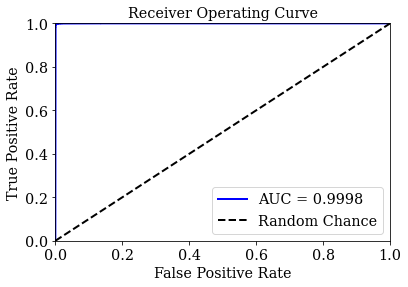

In [12]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(data_test['labels'][:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='AUC = %.4f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random Chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()

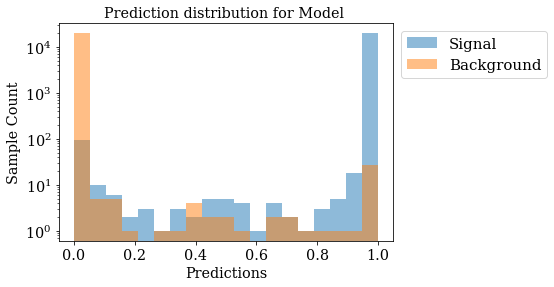

In [13]:
sig = predict[data_test['labels'][:,1]==1][:,1]
bkg = predict[data_test['labels'][:,0]==1][:,1]

bins = np.linspace(0, 1, 20)

plt.hist(sig, bins, alpha=0.5, label='Signal')
plt.hist(bkg, bins, alpha=0.5, label='Background')

plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
plt.title('Prediction distribution for Model ')
plt.xlabel('Predictions')
plt.ylabel('Sample Count')
plt.show()